In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import librosa.display
import matplotlib.pyplot as plt

import random

In [2]:
dataset_path = "dataset/test_cut"#ที่อยู่ของไฟล์ที่จำนำมา train
classes = {folder: idx for idx, folder in enumerate(sorted(os.listdir(dataset_path)))} #ทำการกำหนด class ที่จะนำมา classify

print(classes)  # ตัวอย่าง output: {'broken': 0, 'good': 1, 'overload': 2}


{'engine1_good': 0, 'engine2_broken': 1, 'engine3_heavyload': 2}


In [3]:
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):#เป็น function ในการpreprocess ข้อมูลใน training set โดยจะแปลงไฟล์เสียงเป็น mel spectrogram
    data = []
    labels = []
    
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)
    
    return np.array(data), np.array(labels) #return class และข้อมูลที่ถูกแปลงเรียบร้อยแล้ว


In [4]:
data, labels = load_and_preprocess_data(dataset_path, classes)

In [5]:
def visualize_spectrogram(file_path):#visualize เป็น spectrogram 
    # โหลดไฟล์เสียง
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # แปลงเป็น Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # แสดงผล Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram: {os.path.basename(file_path)}')
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.show()


In [6]:
def visualize_mfcc(file_path, n_mfcc=13): #visualize เป็น mfcc
    # โหลดไฟล์เสียง
    audio_data, sample_rate = librosa.load(file_path, sr=None)

    # แปลงเป็น MFCC
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)

    # แสดงผล MFCC
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', cmap='coolwarm')
    plt.colorbar(label="MFCC Coefficients")
    plt.title(f'MFCC: {os.path.basename(file_path)}')
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.show()


ตัวอย่างไฟล์ ภาพMelspectrogram

In [7]:
test_path_good="dataset/test_cut/engine1_good/atmo_high_0.wav"
test_path_overlaod="dataset/test_cut/engine3_heavyload/atmo_high_10.wav"
test_path_broken="dataset/test_cut/engine2_broken/atmo_high_10.wav"

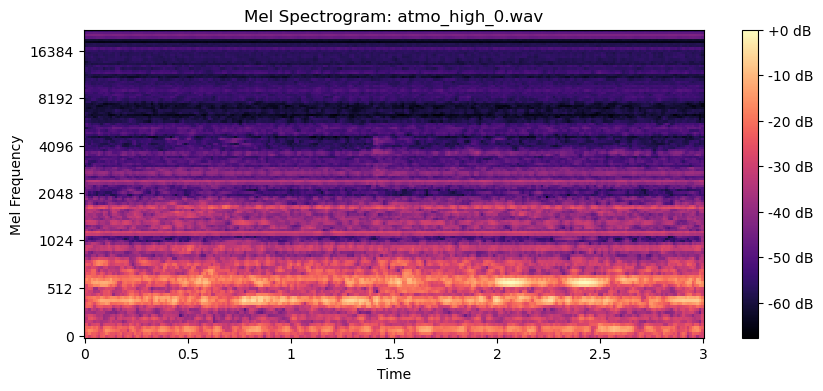

In [8]:
visualize_spectrogram(test_path_good) #good

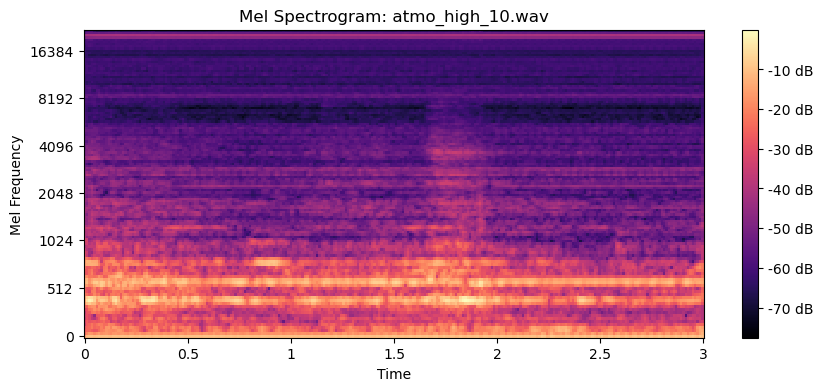

In [9]:
visualize_spectrogram(test_path_overlaod) #overload

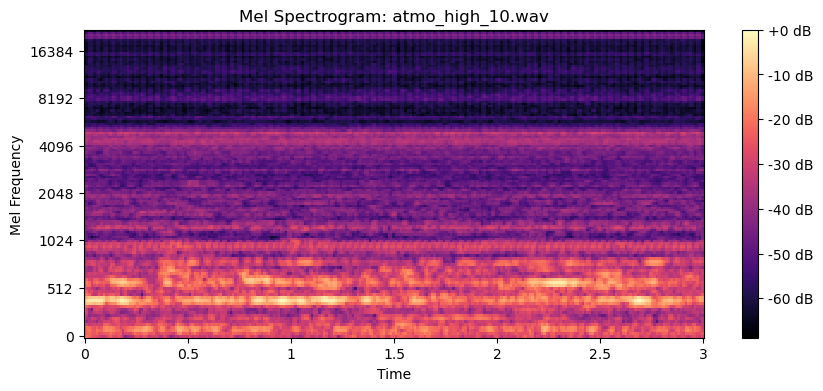

In [10]:
visualize_spectrogram(test_path_broken) #broken

In [11]:
classes 

{'engine1_good': 0, 'engine2_broken': 1, 'engine3_heavyload': 2}

In [12]:
data

array([[[[6.60634518e+00],
         [5.59263754e+00],
         [7.44984770e+00],
         ...,
         [4.01994896e+00],
         [2.17962742e+00],
         [2.48636293e+00]],

        [[1.01006708e+01],
         [1.91552696e+01],
         [9.88488865e+00],
         ...,
         [7.70162344e+00],
         [1.02565336e+01],
         [4.82614088e+00]],

        [[1.99110088e+01],
         [4.54950752e+01],
         [2.18006153e+01],
         ...,
         [2.72785778e+01],
         [5.59041824e+01],
         [1.87144337e+01]],

        ...,

        [[6.77415505e-02],
         [1.05648726e-01],
         [1.15660362e-01],
         ...,
         [1.22865550e-01],
         [1.18385620e-01],
         [9.67428759e-02]],

        [[2.94158496e-02],
         [4.13913988e-02],
         [4.41872589e-02],
         ...,
         [3.84970456e-02],
         [3.69104370e-02],
         [3.42555419e-02]],

        [[9.11129825e-03],
         [9.41569917e-03],
         [1.07707772e-02],
         ...,
 

In [13]:
labels

array([0, 0, 0, ..., 2, 2, 2])

In [14]:
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding

In [15]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [41]:
all_filenames = []
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.wav'):
            all_filenames.append(os.path.join(class_dir, filename))


In [42]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42) #แบ่งข้อมูลในการ train ,test
X_train, X_test, y_train, y_test, X_train_filenames, X_test_filenames = train_test_split(
    data, labels, all_filenames, test_size=0.2, random_state=42
)

In [43]:
#ขั้นตอนการสร้าง model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)#กำหนด input layer โดยใช้ Input() และระบุ input_shape ซึ่งได้มาจาก X_train[0].shape
x = Conv2D(32, (3, 3), activation='relu')(input_layer)#ใช้ฟิลเตอร์ขนาด 3x3 มีจำนวนฟิลเตอร์ 32 ตัว ใช้ฟังก์ชัน ReLU เป็น Activation Function
x = MaxPooling2D((2, 2))(x)#ลดขนาด Feature Map ลงครึ่งหนึ่งโดยใช้ Max Pooling ขนาด 2x2
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)#แปลงข้อมูลจาก Feature Maps ไปเป็น เวกเตอร์ 1 มิติ เพื่อป้อนเข้าสู่ Fully Connected Layer
# x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)#Fully Connected Layer ขนาด 64 neurons พร้อมใช้ L2 Regularization (l2(0.001))
x = Dropout(0.5)(x)  # เพิ่ม Dropout ที่ 50%
output_layer = Dense(len(classes), activation='softmax')(x)#จำนวน neurons เท่ากับ จำนวนคลาส ใช้ Softmax เป็น activation function (เหมาะกับ Multi-class Classification)
model = Model(input_layer, output_layer)#สร้างโมเดลจาก input layer และ output layer

In [44]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
51/51 [==============================] - 2s 27ms/step - loss: 7.4351 - accuracy: 0.7989 - val_loss: 0.5461 - val_accuracy: 0.9383
Epoch 2/20
51/51 [==============================] - 1s 23ms/step - loss: 0.3196 - accuracy: 0.9666 - val_loss: 0.3368 - val_accuracy: 0.9679
Epoch 3/20
51/51 [==============================] - 1s 24ms/step - loss: 0.2373 - accuracy: 0.9709 - val_loss: 0.2363 - val_accuracy: 0.9778
Epoch 4/20
51/51 [==============================] - 1s 24ms/step - loss: 0.1680 - accuracy: 0.9814 - val_loss: 0.2802 - val_accuracy: 0.9827
Epoch 5/20
51/51 [==============================] - 1s 23ms/step - loss: 0.1360 - accuracy: 0.9926 - val_loss: 0.2568 - val_accuracy: 0.9778
Epoch 6/20
51/51 [==============================] - 1s 23ms/step - loss: 0.1259 - accuracy: 0.9907 - val_loss: 0.2071 - val_accuracy: 0.9778
Epoch 7/20
51/51 [==============================] - 1s 24ms/step - loss: 0.1210 - accuracy: 0.9851 - val_loss: 0.1512 - val_accuracy: 0.9802
Epoch 8/20
51

In [46]:
# Train loss & accuracy
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

# Test loss & accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Loss: 0.0946
Train Accuracy: 0.9926
Test Loss: 0.7049
Test Accuracy: 0.9852


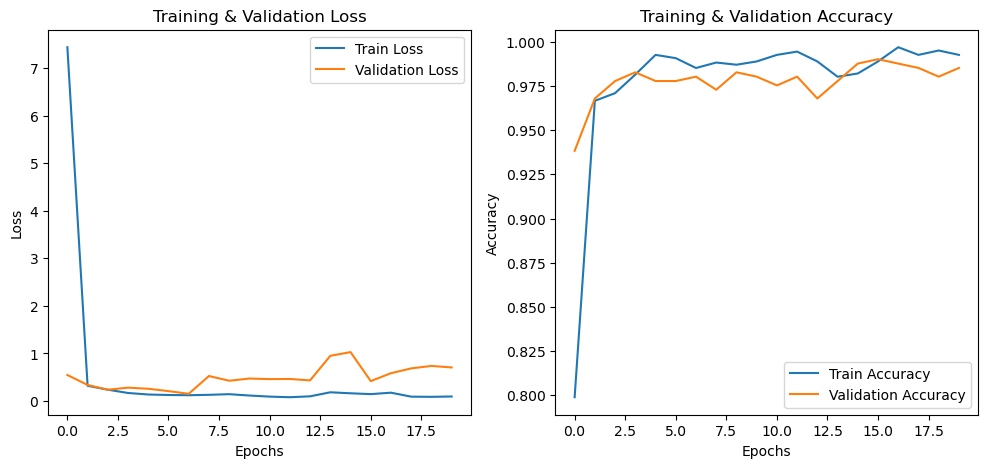

In [47]:
import matplotlib.pyplot as plt

# ดึงค่าประวัติการ train จาก model
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

สำหรับกราฟ Train Loss และ Validation Loss
ในช่วงแรก (Epoch ที่ 0-2) ค่า Loss ลดลงอย่างรวดเร็ว ซึ่งบ่งบอกว่าโมเดลกำลังเรียนรู้ได้ดี
Train Loss ลดลงอย่างต่อเนื่องจนใกล้ศูนย์ ซึ่งแสดงว่าโมเดลสามารถปรับพารามิเตอร์ให้เหมาะสมกับชุดข้อมูลฝึก
Validation Loss มีความผันผวนเล็กน้อย แต่ค่อนข้างคงที่หลังจาก Epoch ที่ 5 ซึ่งบ่งบอกว่าโมเดลไม่ได้ Overfitting มากนัก

สำหรับกราฟ Train accuracy และ Validation accuracy
ช่วงแรก (Epoch 0-3) ค่า Accuracy เพิ่มขึ้นอย่างรวดเร็ว
หลังจาก Epoch ที่ 5 ค่า Accuracy คงที่เกือบ 100% สำหรับทั้ง Train และ Validation ซึ่งหมายความว่าโมเดลเรียนรู้ได้ดีและไม่ได้ Overfitting มากนัก
Validation Accuracy สูงใกล้เคียงกับ Train Accuracy ตลอดช่วงการฝึก


13/13 [==============================] - 0s 29ms/step


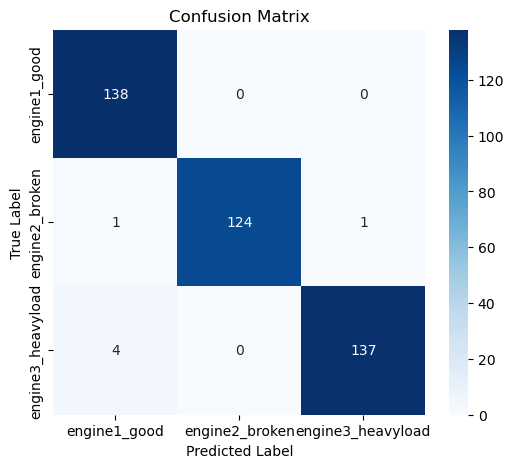


ไฟล์ที่ทายผิด:
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav, ทายเป็น: engine1_good, ค่าจริง: engine2_broken
ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_3.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_56.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine2_broken\stresstest_14.wav, ทายเป็น: engine3_heavyload, ค่าจริง: engine2_broken
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)

# แปลง one-hot encoding กลับเป็น label เดียว เช่น [0,1,0] → 1
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# ชื่อคลาสจาก Dictionary ที่สร้างไว้
class_labels = list(classes.keys())

# แสดง Confusion Matrix ด้วย heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# หาดัชนีที่ทายผิด
misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]

# แสดงรายการไฟล์ที่ทายผิด
print("\nไฟล์ที่ทายผิด:")
for idx in misclassified_indices:
    print(f"ไฟล์: {X_test_filenames[idx]}, ทายเป็น: {class_labels[y_pred_labels[idx]]}, ค่าจริง: {class_labels[y_true_labels[idx]]}")



1/1 [==============================] - 0s 17ms/step


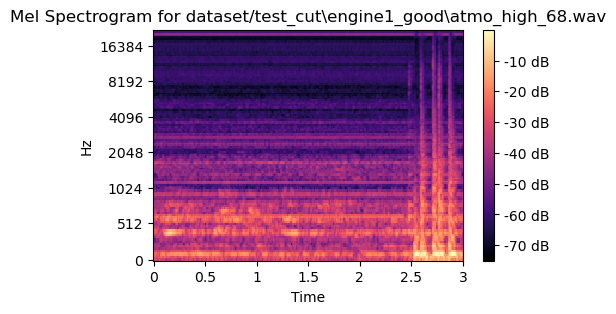

ไฟล์: dataset/test_cut\engine1_good\atmo_high_68.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 18ms/step


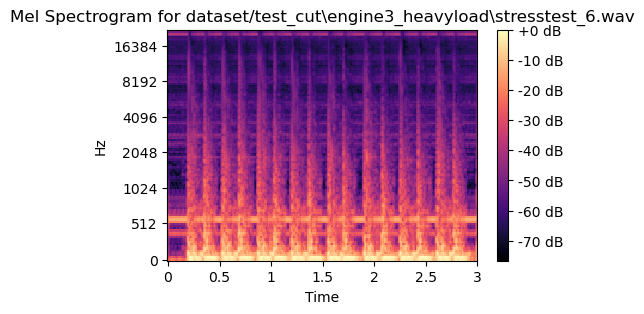

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 22ms/step


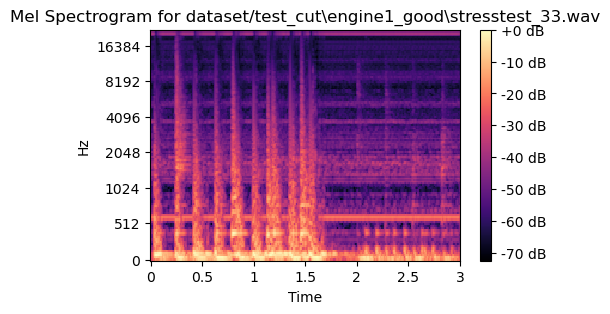

ไฟล์: dataset/test_cut\engine1_good\stresstest_33.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 21ms/step


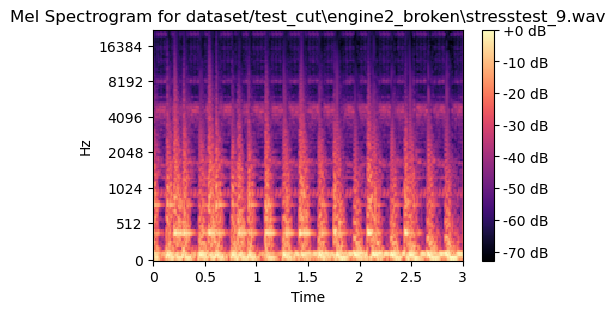

ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 22ms/step


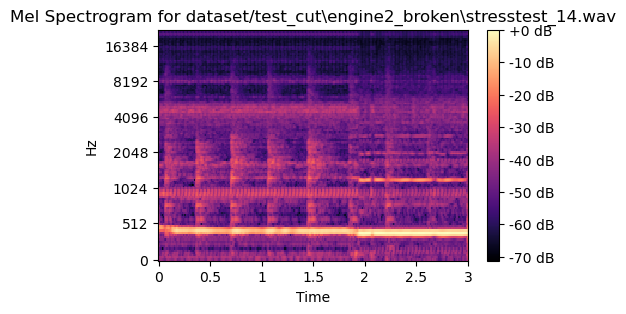

ไฟล์: dataset/test_cut\engine2_broken\stresstest_14.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 25ms/step


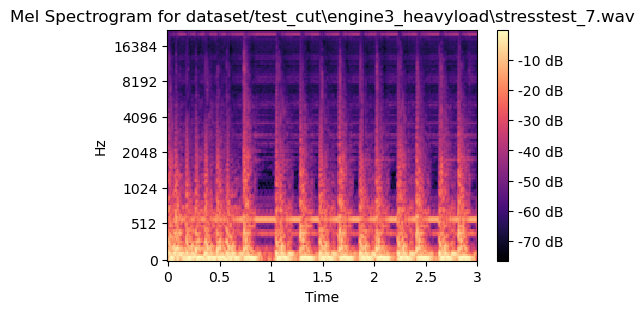

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 21ms/step


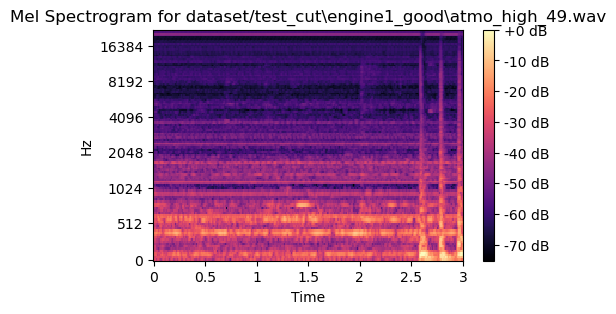

ไฟล์: dataset/test_cut\engine1_good\atmo_high_49.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 25ms/step
พบไฟล์ที่ทายผิดทั้งหมด 7 ไฟล์


In [77]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import resize

def visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes, target_shape=(128, 128)):
    """
    ฟังก์ชันแสดงไฟล์ทั้งหมดที่การทายผิดพร้อมทั้งผลทำนายและคำตอบจริง
    Args:
        model: โมเดลที่ฝึกมาแล้ว
        X_test: ชุดข้อมูลทดสอบ (Mel spectrograms)
        y_test: คำตอบจริง (one-hot encoded labels)
        X_test_filenames: ชื่อไฟล์ของชุดทดสอบ
        classes: Dictionary ของชื่อคลาส
        target_shape: ขนาดของ Mel Spectrogram ที่จะใช้
    """
    misclassified_indices = []
    
    for idx in range(len(X_test)):
        # ทำนายผล
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        predicted_label = np.argmax(prediction, axis=1)
        true_label = np.argmax(y_test[idx], axis=0)
        
        # ตรวจสอบว่าทำนายผิด
        if predicted_label != true_label:
            misclassified_indices.append(idx)
            
            # โหลดไฟล์เสียงและแปลงเป็น Mel spectrogram
            file_path = X_test_filenames[idx]
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # แปลงเป็น dB scale
            
            # ปรับขนาดให้ตรงกับ target_shape
            mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
            
            # แสดง Mel Spectrogram
            plt.figure(figsize=(5, 3))
            librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel Spectrogram for {file_path}")
            plt.show()

            # แสดงผลการทำนายและคำตอบจริง
            predicted_class = list(classes.keys())[predicted_label[0]]
            true_class = list(classes.keys())[true_label]
            
            print(f"ไฟล์: {file_path}")
            print(f"ผลการทำนาย: {predicted_class} (คลาสที่ทำนาย: {predicted_label[0]})")
            print(f"คำตอบจริง: {true_class} (คลาสจริง: {true_label})\n")

    if not misclassified_indices:
        print("ไม่มีไฟล์ที่ทายผิด")
    else:
        print(f"พบไฟล์ที่ทายผิดทั้งหมด {len(misclassified_indices)} ไฟล์")

# ตัวอย่างการใช้ฟังก์ชัน
visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes)


1.engine1_good (เครื่องยนต์ปกติ)

โมเดลทำนายถูกต้อง 135 ครั้ง
ทำนายผิดเป็น engine2_broken 3 ครั้ง
ไม่มีการทำนายผิดเป็น engine3_heavyload
2.engine2_broken (เครื่องยนต์เสีย)

โมเดลทำนายถูกต้อง 124 ครั้ง
ทำนายผิดเป็น engine1_good 1 ครั้ง
ทำนายผิดเป็น engine3_heavyload 1 ครั้ง
3.engine3_heavyload (เครื่องยนต์ทำงานหนัก)

โมเดลทำนายถูกต้อง 139 ครั้ง
ทำนายผิดเป็น engine1_good 2 ครั้ง
ไม่มีการทำนายผิดเป็น engine2_broken

In [63]:
from sklearn.metrics import classification_report

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ใช้ classification_report เพื่อแสดง Precision, Recall, F1-Score
print(classification_report(y_true_labels, y_pred_classes, target_names=class_labels))


13/13 [==============================] - 0s 30ms/step
                   precision    recall  f1-score   support

     engine1_good       0.98      0.98      0.98       138
   engine2_broken       0.98      0.98      0.98       126
engine3_heavyload       0.99      0.99      0.99       141

         accuracy                           0.98       405
        macro avg       0.98      0.98      0.98       405
     weighted avg       0.98      0.98      0.98       405



Testing model

In [64]:
model.save('CNN-save2.h5')

In [72]:
model = load_model('CNN-save2.h5')

1/1 [==============================] - 0s 22ms/step


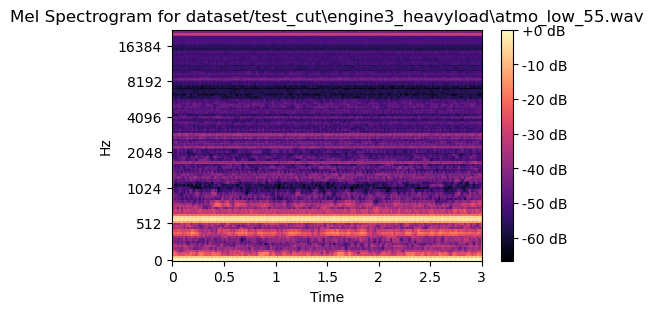

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_low_55.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 20ms/step


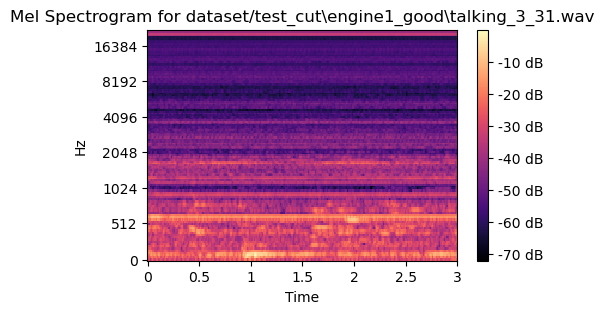

ไฟล์: dataset/test_cut\engine1_good\talking_3_31.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 18ms/step


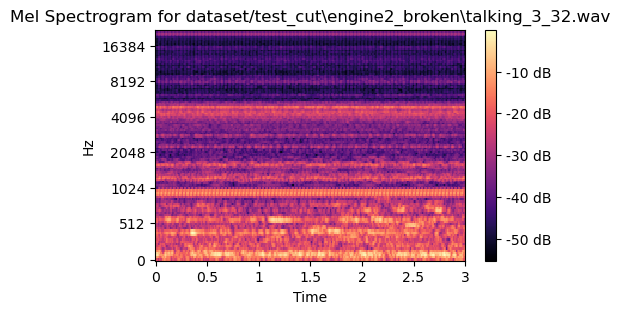

ไฟล์: dataset/test_cut\engine2_broken\talking_3_32.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 18ms/step


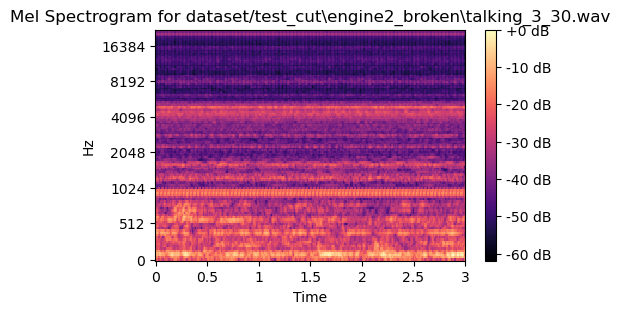

ไฟล์: dataset/test_cut\engine2_broken\talking_3_30.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 18ms/step


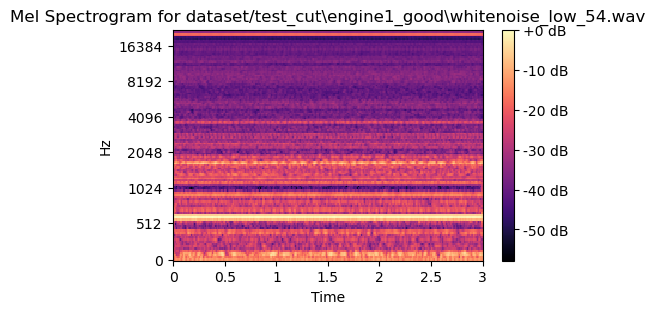

ไฟล์: dataset/test_cut\engine1_good\whitenoise_low_54.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 17ms/step


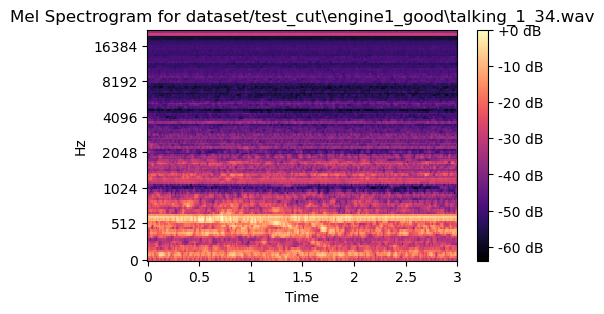

ไฟล์: dataset/test_cut\engine1_good\talking_1_34.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 18ms/step


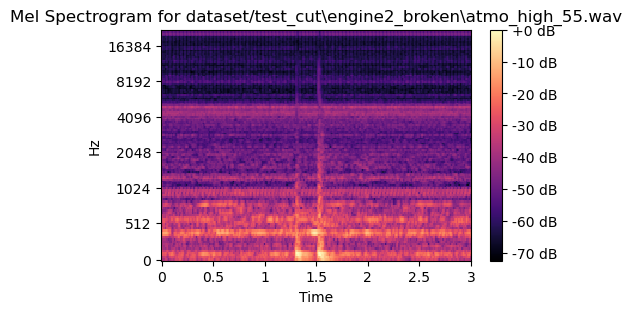

ไฟล์: dataset/test_cut\engine2_broken\atmo_high_55.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 17ms/step


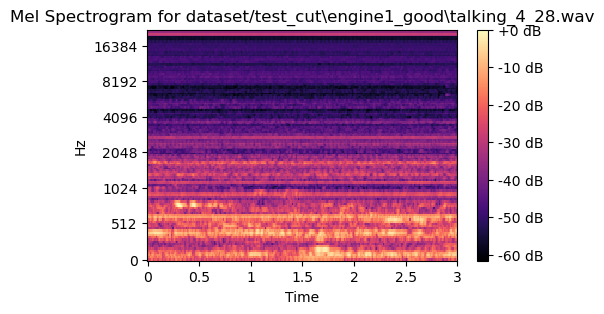

ไฟล์: dataset/test_cut\engine1_good\talking_4_28.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 17ms/step


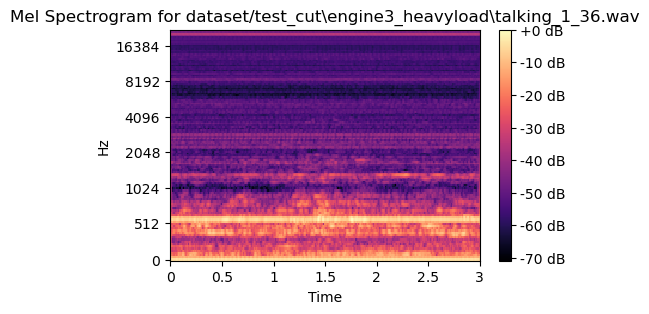

ไฟล์: dataset/test_cut\engine3_heavyload\talking_1_36.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 18ms/step


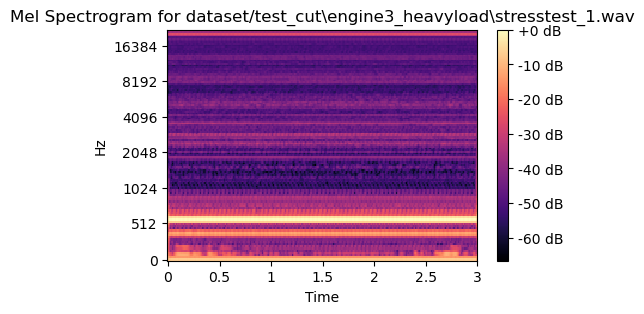

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_1.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)



In [78]:
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import resize

def visualize_random_files(model, X_test, y_test, X_test_filenames, classes, target_shape=(128, 128), num_files=10):
    """
    ฟังก์ชันแสดง Mel Spectrogram สำหรับไฟล์ที่สุ่มเลือกจากชุดข้อมูลทดสอบ
    Args:
        model: โมเดลที่ฝึกมาแล้ว
        X_test: ชุดข้อมูลทดสอบ (Mel spectrograms)
        y_test: คำตอบจริง (one-hot encoded labels)
        X_test_filenames: ชื่อไฟล์ของชุดทดสอบ
        classes: Dictionary ของชื่อคลาส
        target_shape: ขนาดของ Mel Spectrogram ที่จะใช้
        num_files: จำนวนไฟล์ที่ต้องการแสดง
    """
    # สุ่มไฟล์จากชุดทดสอบ
    random_indices = random.sample(range(len(X_test)), num_files)
    
    for idx in random_indices:
        # ทำนายผล
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        predicted_label = np.argmax(prediction, axis=1)
        true_label = np.argmax(y_test[idx], axis=0)
        
        # โหลดไฟล์เสียงและแปลงเป็น Mel spectrogram
        file_path = X_test_filenames[idx]
        audio_data, sample_rate = librosa.load(file_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # แปลงเป็น dB scale
        
        # ปรับขนาดให้ตรงกับ target_shape
        mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        
        # แสดง Mel Spectrogram
        plt.figure(figsize=(5, 3))
        librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram for {file_path}")
        plt.show()

        # แสดงผลการทำนายและคำตอบจริง
        predicted_class = list(classes.keys())[predicted_label[0]]
        true_class = list(classes.keys())[true_label]
        
        print(f"ไฟล์: {file_path}")
        print(f"ผลการทำนาย: {predicted_class} (คลาสที่ทำนาย: {predicted_label[0]})")
        print(f"คำตอบจริง: {true_class} (คลาสจริง: {true_label})\n")

# ตัวอย่างการใช้ฟังก์ชัน
visualize_random_files(model, X_test, y_test, X_test_filenames, classes, num_files=10)


เป็นการนำเอาโมเดลไปใช้งานสุ่ม10ไฟล์

1/1 [==============================] - 0s 88ms/step
Audio file: dataset/test_cut\engine1_good\atmo_high_11.wav
Predicted class: engine1_good
True class: engine1_good


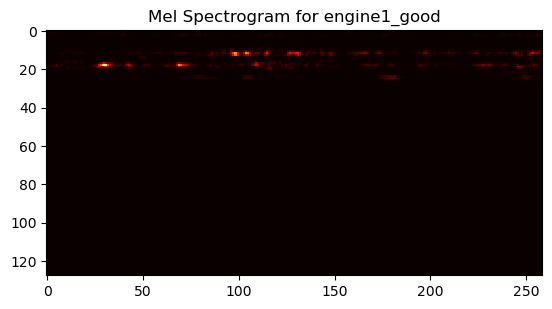

1/1 [==============================] - 0s 24ms/step
Audio file: dataset/test_cut\engine2_broken\talking_1_47.wav
Predicted class: engine2_broken
True class: engine2_broken


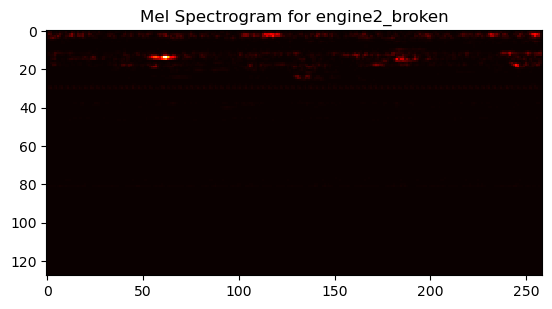

1/1 [==============================] - 0s 23ms/step
Audio file: dataset/test_cut\engine3_heavyload\talking_2_46.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


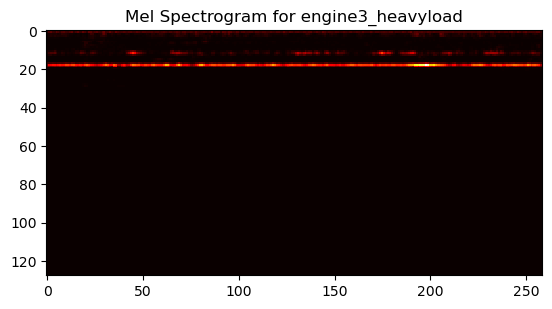

1/1 [==============================] - 0s 18ms/step
Audio file: dataset/test_cut\engine2_broken\whitenoise_low_109.wav
Predicted class: engine2_broken
True class: engine2_broken


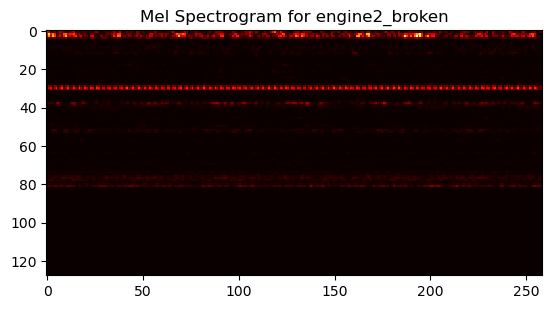

1/1 [==============================] - 0s 25ms/step
Audio file: dataset/test_cut\engine3_heavyload\atmo_low_56.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


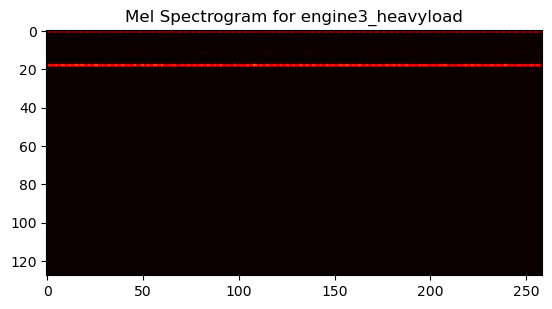

1/1 [==============================] - 0s 28ms/step
Audio file: dataset/test_cut\engine1_good\talking_3_26.wav
Predicted class: engine1_good
True class: engine1_good


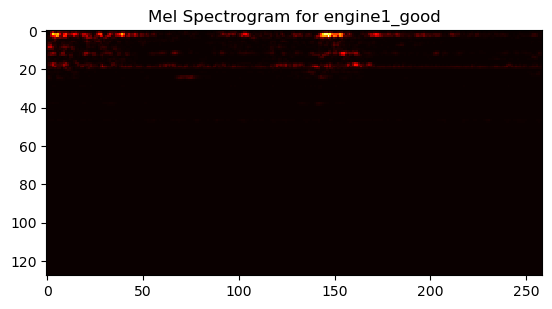

1/1 [==============================] - 0s 26ms/step
Audio file: dataset/test_cut\engine1_good\talking_3_35.wav
Predicted class: engine1_good
True class: engine1_good


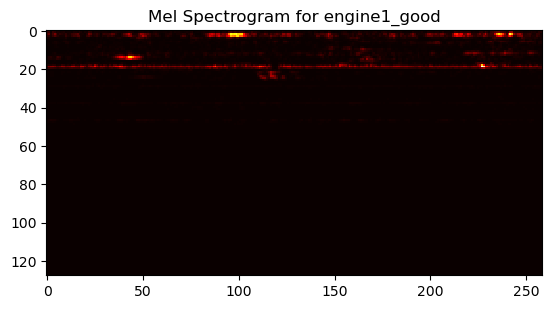

1/1 [==============================] - 0s 37ms/step
Audio file: dataset/test_cut\engine2_broken\atmo_medium_42.wav
Predicted class: engine2_broken
True class: engine2_broken


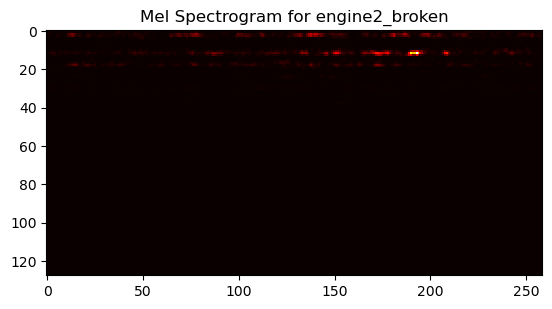

1/1 [==============================] - 0s 31ms/step
Audio file: dataset/test_cut\engine3_heavyload\whitenoise_low_17.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


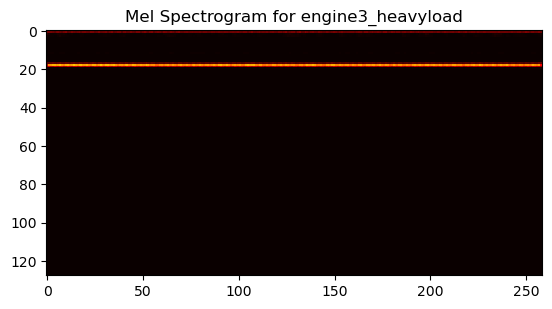

1/1 [==============================] - 0s 26ms/step
Audio file: dataset/test_cut\engine3_heavyload\whitenoise_low_26.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


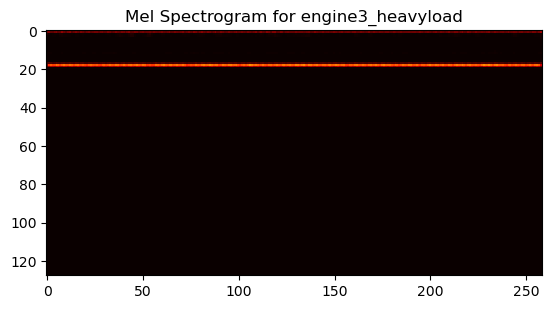

In [70]:
import os
import random
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.image import resize
import matplotlib.pyplot as plt

# โหลดโมเดลที่เทรนแล้ว
model = load_model('CNN-save2.h5')  # เปลี่ยน path ตามที่คุณเก็บโมเดล

# ฟังก์ชันในการเตรียมข้อมูลเสียง
def preprocess_audio(file_path, target_shape=(128, 128)):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # แปลงเป็น Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    
    # ปรับขนาด Mel Spectrogram ให้ตรงกับขนาดที่โมเดลต้องการ
    mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    
    return mel_spectrogram_resized

# กำหนดโฟลเดอร์ที่เก็บไฟล์เสียง
dataset_path = "dataset/test_cut"  # เปลี่ยน path ตามที่คุณเก็บไฟล์เสียง
all_files = []

# สร้างลิสต์ของไฟล์ทั้งหมดในโฟลเดอร์
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        all_files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.wav')])

# ตรวจสอบจำนวนไฟล์ทั้งหมดในโฟลเดอร์
if len(all_files) >= 5:
    # สุ่มไฟล์เสียง 5 ไฟล์
    random_files = random.sample(all_files, 10)
else:
    print(f"มีไฟล์เสียงทั้งหมด {len(all_files)} ไฟล์ ซึ่งน้อยกว่าจำนวนที่ต้องการสุ่ม (5 ไฟล์)")
    random_files = all_files  # ใช้ไฟล์ทั้งหมดแทน

# ทำนายและแสดงผลสำหรับไฟล์ที่สุ่ม
for audio_file in random_files:
    # ประมวลผลไฟล์เสียง
    processed_audio = preprocess_audio(audio_file)

    # เปลี่ยนเป็น batch ข้อมูลเพื่อให้เข้ากับโมเดล
    processed_audio = np.expand_dims(processed_audio, axis=0)  # เพิ่มมิติ batch ขึ้นมา

    # ทำนายคลาส
    prediction = model.predict(processed_audio)

    # หาค่าคลาสที่มีความน่าจะเป็นสูงสุด
    predicted_class = np.argmax(prediction)

    # หา class จริงจากโฟลเดอร์ของไฟล์
    true_class = audio_file.split(os.sep)[-2]  # ใช้ชื่อโฟลเดอร์เป็น class จริง

    # แสดงผลการทำนาย
    print(f"Audio file: {audio_file}")
    print(f"Predicted class: {list(classes.keys())[predicted_class]}")
    print(f"True class: {true_class}")

    # แสดง Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=librosa.load(audio_file, sr=None)[0], sr=librosa.load(audio_file, sr=None)[1])
    plt.imshow(mel_spectrogram, cmap='hot', interpolation='nearest')
    plt.title(f'Mel Spectrogram for {list(classes.keys())[predicted_class]}')
    plt.show()


1/1 [==============================] - 0s 79ms/step
Audio file: dataset/test_cut\engine3_heavyload\talking_4_46.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


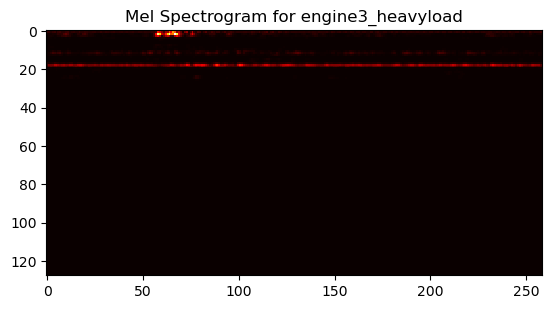

1/1 [==============================] - 0s 20ms/step
Audio file: dataset/test_cut\engine1_good\talking_3_12.wav
Predicted class: engine1_good
True class: engine1_good


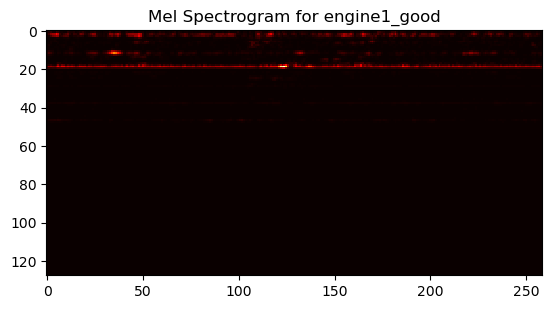

1/1 [==============================] - 0s 19ms/step
Audio file: dataset/test_cut\engine2_broken\whitenoise_low_32.wav
Predicted class: engine2_broken
True class: engine2_broken


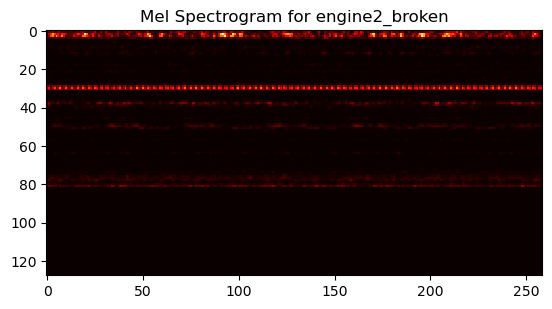

1/1 [==============================] - 0s 22ms/step
Audio file: dataset/test_cut\engine2_broken\talking_2_6.wav
Predicted class: engine2_broken
True class: engine2_broken


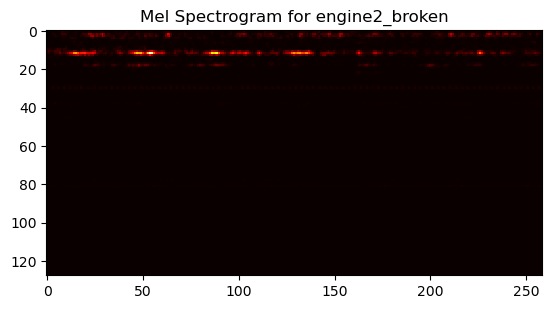

1/1 [==============================] - 0s 18ms/step
Audio file: dataset/test_cut\engine2_broken\atmo_medium_27.wav
Predicted class: engine2_broken
True class: engine2_broken


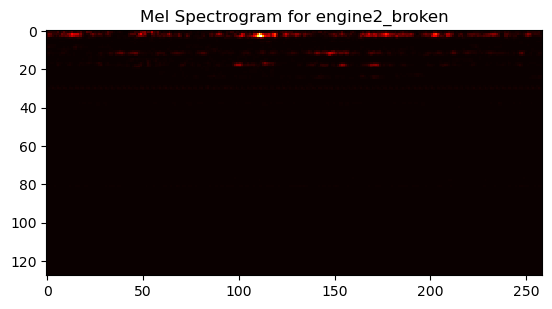

1/1 [==============================] - 0s 19ms/step
Audio file: dataset/test_cut\engine2_broken\talking_4_36.wav
Predicted class: engine2_broken
True class: engine2_broken


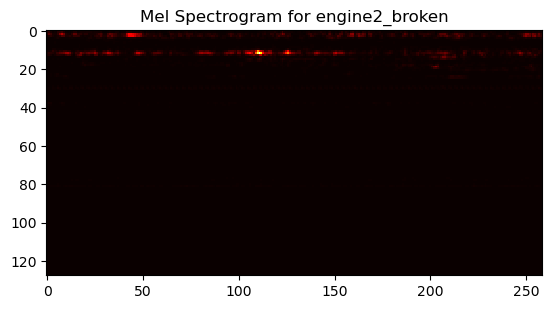

1/1 [==============================] - 0s 19ms/step
Audio file: dataset/test_cut\engine2_broken\talking_4_5.wav
Predicted class: engine2_broken
True class: engine2_broken


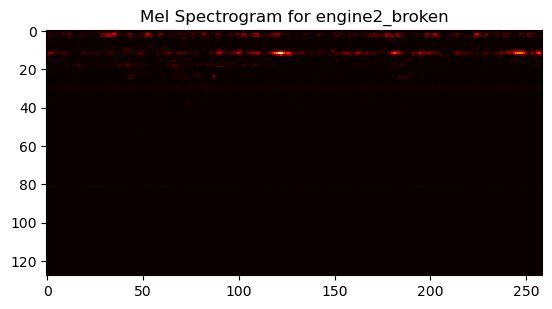

1/1 [==============================] - 0s 19ms/step
Audio file: dataset/test_cut\engine2_broken\talking_3_47.wav
Predicted class: engine2_broken
True class: engine2_broken


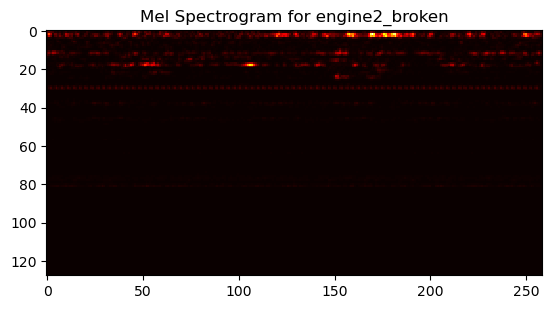

1/1 [==============================] - 0s 19ms/step
Audio file: dataset/test_cut\engine2_broken\whitenoise_low_113.wav
Predicted class: engine2_broken
True class: engine2_broken


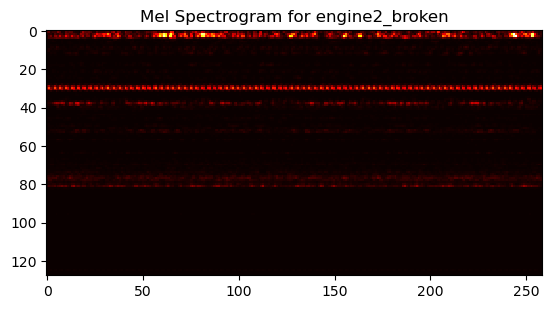

1/1 [==============================] - 0s 20ms/step
Audio file: dataset/test_cut\engine3_heavyload\stresstest_36.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


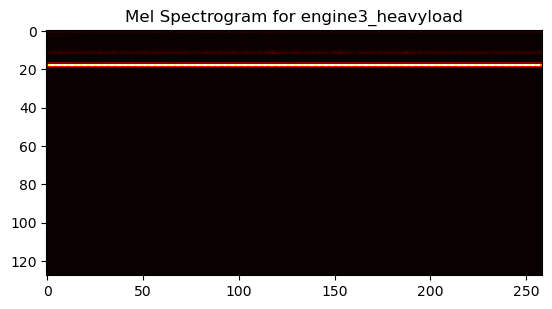

1/1 [==============================] - 0s 21ms/step
Audio file: dataset/test_cut\engine2_broken\whitenoise_low_98.wav
Predicted class: engine2_broken
True class: engine2_broken


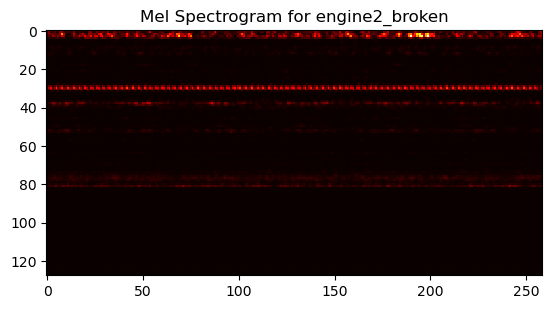

1/1 [==============================] - 0s 22ms/step
Audio file: dataset/test_cut\engine2_broken\talking_2_35.wav
Predicted class: engine2_broken
True class: engine2_broken


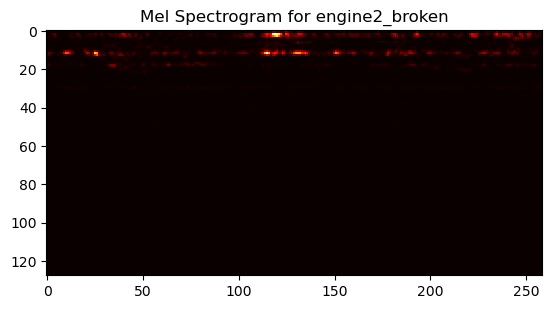

1/1 [==============================] - 0s 17ms/step
Audio file: dataset/test_cut\engine1_good\atmo_medium_13.wav
Predicted class: engine1_good
True class: engine1_good


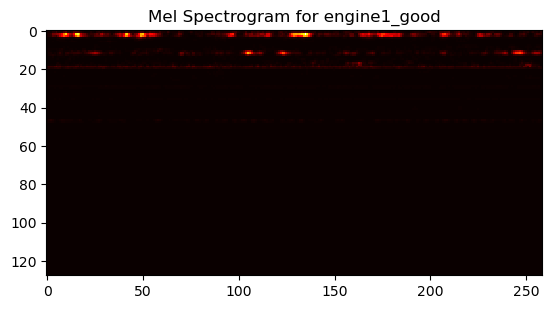

1/1 [==============================] - 0s 18ms/step
Audio file: dataset/test_cut\engine1_good\atmo_low_28.wav
Predicted class: engine1_good
True class: engine1_good


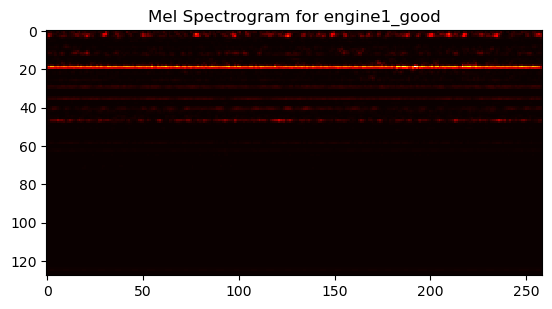

1/1 [==============================] - 0s 23ms/step
Audio file: dataset/test_cut\engine2_broken\atmo_low_57.wav
Predicted class: engine2_broken
True class: engine2_broken


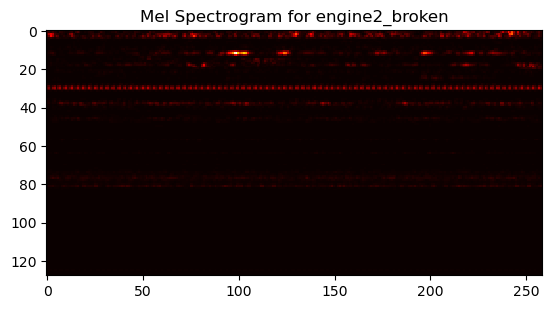

1/1 [==============================] - 0s 22ms/step
Audio file: dataset/test_cut\engine2_broken\talking_1_54.wav
Predicted class: engine2_broken
True class: engine2_broken


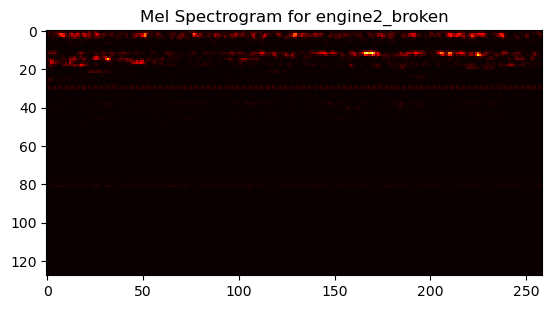

1/1 [==============================] - 0s 18ms/step
Audio file: dataset/test_cut\engine3_heavyload\talking_4_7.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


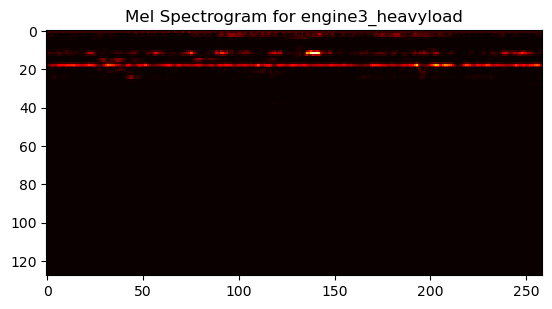

1/1 [==============================] - 0s 18ms/step
Audio file: dataset/test_cut\engine1_good\atmo_medium_59.wav
Predicted class: engine1_good
True class: engine1_good


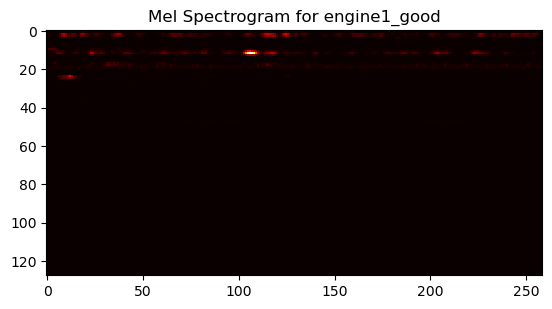

1/1 [==============================] - 0s 22ms/step
Audio file: dataset/test_cut\engine3_heavyload\whitenoise_low_80.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


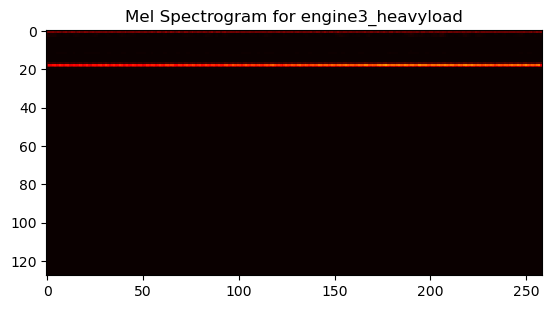

1/1 [==============================] - 0s 24ms/step
Audio file: dataset/test_cut\engine3_heavyload\atmo_medium_22.wav
Predicted class: engine3_heavyload
True class: engine3_heavyload


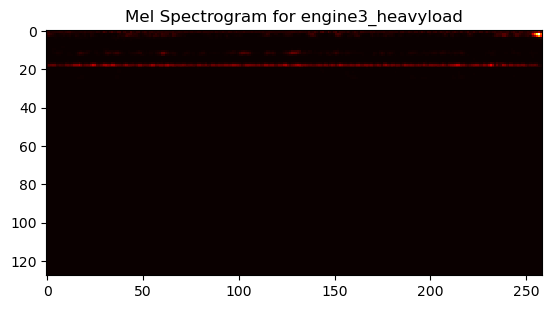

In [28]:
model = load_model('CNN-save2.h5')  # เปลี่ยน path ตามที่คุณเก็บโมเดล

# ฟังก์ชันในการเตรียมข้อมูลเสียง
def preprocess_audio(file_path, target_shape=(128, 128)):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # แปลงเป็น Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    
    # ปรับขนาด Mel Spectrogram ให้ตรงกับขนาดที่โมเดลต้องการ
    mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    
    return mel_spectrogram_resized

# กำหนดโฟลเดอร์ที่เก็บไฟล์เสียง
dataset_path = "dataset/test_cut"  # เปลี่ยน path ตามที่คุณเก็บไฟล์เสียง
all_files = []

# สร้างลิสต์ของไฟล์ทั้งหมดในโฟลเดอร์
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        all_files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.wav')])

# ตรวจสอบจำนวนไฟล์ทั้งหมดในโฟลเดอร์
if len(all_files) >= 20:
    # สุ่มไฟล์เสียง 5 ไฟล์
    random_files = random.sample(all_files, 20)
else:
    print(f"มีไฟล์เสียงทั้งหมด {len(all_files)} ไฟล์ ซึ่งน้อยกว่าจำนวนที่ต้องการสุ่ม (5 ไฟล์)")
    random_files = all_files  # ใช้ไฟล์ทั้งหมดแทน

# ทำนายและแสดงผลสำหรับไฟล์ที่สุ่ม
for audio_file in random_files:
    # ประมวลผลไฟล์เสียง
    processed_audio = preprocess_audio(audio_file)

    # เปลี่ยนเป็น batch ข้อมูลเพื่อให้เข้ากับโมเดล
    processed_audio = np.expand_dims(processed_audio, axis=0)  # เพิ่มมิติ batch ขึ้นมา

    # ทำนายคลาส
    prediction = model.predict(processed_audio)

    # หาค่าคลาสที่มีความน่าจะเป็นสูงสุด
    predicted_class = np.argmax(prediction)

    # หา class จริงจากโฟลเดอร์ของไฟล์
    true_class = audio_file.split(os.sep)[-2]  # ใช้ชื่อโฟลเดอร์เป็น class จริง

    # แสดงผลการทำนาย
    print(f"Audio file: {audio_file}")
    print(f"Predicted class: {list(classes.keys())[predicted_class]}")
    print(f"True class: {true_class}")

    # แสดง Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=librosa.load(audio_file, sr=None)[0], sr=librosa.load(audio_file, sr=None)[1])
    plt.imshow(mel_spectrogram, cmap='hot', interpolation='nearest')
    plt.title(f'Mel Spectrogram for {list(classes.keys())[predicted_class]}')
    plt.show()

เป็นการนำเอาโมเดลไปใช้งานสุ่ม10ไฟล์ จากอีก folder trina_cut

In [ ]:
model = load_model('CNN-save2.h5')  # เปลี่ยน path ตามที่คุณเก็บโมเดล

# ฟังก์ชันในการเตรียมข้อมูลเสียง
def preprocess_audio(file_path, target_shape=(128, 128)):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # แปลงเป็น Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    
    # ปรับขนาด Mel Spectrogram ให้ตรงกับขนาดที่โมเดลต้องการ
    mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    
    return mel_spectrogram_resized

# กำหนดโฟลเดอร์ที่เก็บไฟล์เสียง
dataset_path = "dataset/train_cut"  # เปลี่ยน path ตามที่คุณเก็บไฟล์เสียง
all_files = []

# สร้างลิสต์ของไฟล์ทั้งหมดในโฟลเดอร์
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        all_files.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith('.wav')])

# ตรวจสอบจำนวนไฟล์ทั้งหมดในโฟลเดอร์
if len(all_files) >= 20:
    # สุ่มไฟล์เสียง 5 ไฟล์
    random_files = random.sample(all_files, 20)
else:
    print(f"มีไฟล์เสียงทั้งหมด {len(all_files)} ไฟล์ ซึ่งน้อยกว่าจำนวนที่ต้องการสุ่ม (5 ไฟล์)")
    random_files = all_files  # ใช้ไฟล์ทั้งหมดแทน

# ทำนายและแสดงผลสำหรับไฟล์ที่สุ่ม
for audio_file in random_files:
    # ประมวลผลไฟล์เสียง
    processed_audio = preprocess_audio(audio_file)

    # เปลี่ยนเป็น batch ข้อมูลเพื่อให้เข้ากับโมเดล
    processed_audio = np.expand_dims(processed_audio, axis=0)  # เพิ่มมิติ batch ขึ้นมา

    # ทำนายคลาส
    prediction = model.predict(processed_audio)

    # หาค่าคลาสที่มีความน่าจะเป็นสูงสุด
    predicted_class = np.argmax(prediction)

    # หา class จริงจากโฟลเดอร์ของไฟล์
    true_class = audio_file.split(os.sep)[-2]  # ใช้ชื่อโฟลเดอร์เป็น class จริง

    # แสดงผลการทำนาย
    print(f"Audio file: {audio_file}")
    print(f"Predicted class: {list(classes.keys())[predicted_class]}")
    print(f"True class: {true_class}")

    # แสดง Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=librosa.load(audio_file, sr=None)[0], sr=librosa.load(audio_file, sr=None)[1])
    plt.imshow(mel_spectrogram, cmap='hot', interpolation='nearest')
    plt.title(f'Mel Spectrogram for {list(classes.keys())[predicted_class]}')
    plt.show()

Epoch 100

In [80]:
#ขั้นตอนการสร้าง model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)#กำหนด input layer โดยใช้ Input() และระบุ input_shape ซึ่งได้มาจาก X_train[0].shape
x = Conv2D(32, (3, 3), activation='relu')(input_layer)#ใช้ฟิลเตอร์ขนาด 3x3 มีจำนวนฟิลเตอร์ 32 ตัว ใช้ฟังก์ชัน ReLU เป็น Activation Function
x = MaxPooling2D((2, 2))(x)#ลดขนาด Feature Map ลงครึ่งหนึ่งโดยใช้ Max Pooling ขนาด 2x2
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)#แปลงข้อมูลจาก Feature Maps ไปเป็น เวกเตอร์ 1 มิติ เพื่อป้อนเข้าสู่ Fully Connected Layer
# x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)#Fully Connected Layer ขนาด 64 neurons พร้อมใช้ L2 Regularization (l2(0.001))
x = Dropout(0.5)(x)  # เพิ่ม Dropout ที่ 50%
output_layer = Dense(len(classes), activation='softmax')(x)#จำนวน neurons เท่ากับ จำนวนคลาส ใช้ Softmax เป็น activation function (เหมาะกับ Multi-class Classification)
model = Model(input_layer, output_layer)#สร้างโมเดลจาก input layer และ output layer

In [81]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
51/51 [==============================] - 2s 28ms/step - loss: 5.2640 - accuracy: 0.8150 - val_loss: 0.3950 - val_accuracy: 0.9259
Epoch 2/100
51/51 [==============================] - 1s 24ms/step - loss: 0.3491 - accuracy: 0.9437 - val_loss: 0.3045 - val_accuracy: 0.9481
Epoch 3/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2136 - accuracy: 0.9672 - val_loss: 0.2868 - val_accuracy: 0.9704
Epoch 4/100
51/51 [==============================] - 1s 24ms/step - loss: 0.3526 - accuracy: 0.9765 - val_loss: 0.3527 - val_accuracy: 0.9654
Epoch 5/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2175 - accuracy: 0.9734 - val_loss: 0.2831 - val_accuracy: 0.9556
Epoch 6/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1412 - accuracy: 0.9889 - val_loss: 0.2572 - val_accuracy: 0.9778
Epoch 7/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1305 - accuracy: 0.9913 - val_loss: 0.2026 - val_accuracy: 0.9753
Epoch 

In [83]:
# Train loss & accuracy
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

# Test loss & accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Loss: 0.0332
Train Accuracy: 1.0000
Test Loss: 0.4070
Test Accuracy: 0.9975


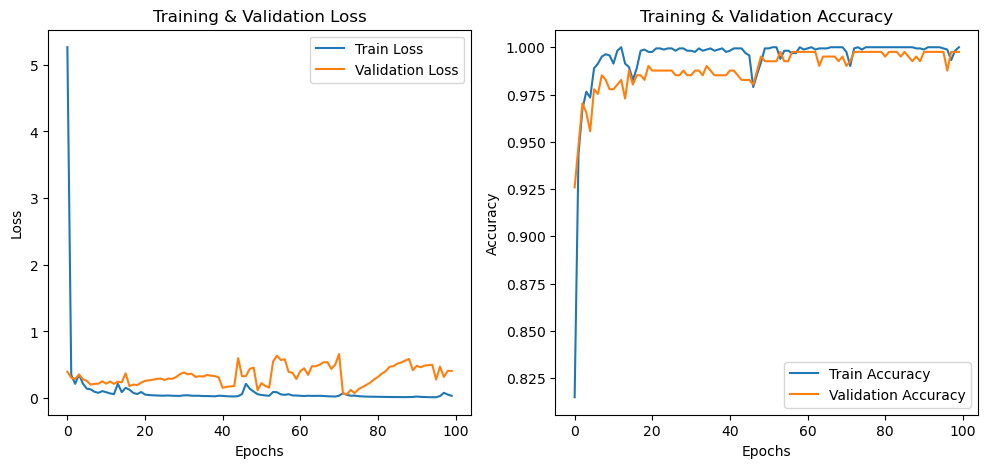

In [84]:
import matplotlib.pyplot as plt

# ดึงค่าประวัติการ train จาก model
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

13/13 [==============================] - 0s 27ms/step


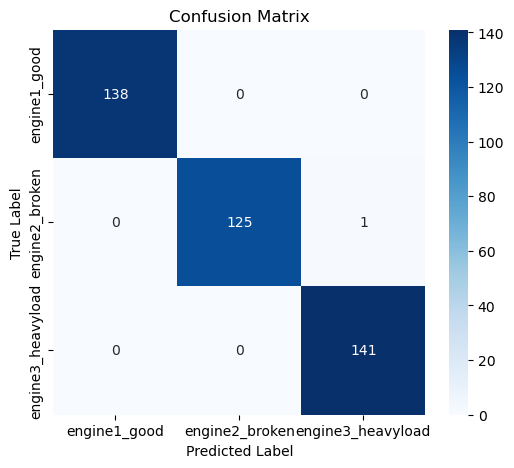


ไฟล์ที่ทายผิด:
ไฟล์: dataset/test_cut\engine2_broken\stresstest_14.wav, ทายเป็น: engine3_heavyload, ค่าจริง: engine2_broken


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)

# แปลง one-hot encoding กลับเป็น label เดียว เช่น [0,1,0] → 1
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# ชื่อคลาสจาก Dictionary ที่สร้างไว้
class_labels = list(classes.keys())

# แสดง Confusion Matrix ด้วย heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# หาดัชนีที่ทายผิด
misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]

# แสดงรายการไฟล์ที่ทายผิด
print("\nไฟล์ที่ทายผิด:")
for idx in misclassified_indices:
    print(f"ไฟล์: {X_test_filenames[idx]}, ทายเป็น: {class_labels[y_pred_labels[idx]]}, ค่าจริง: {class_labels[y_true_labels[idx]]}")



In [87]:
from sklearn.metrics import classification_report

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ใช้ classification_report เพื่อแสดง Precision, Recall, F1-Score
print(classification_report(y_true_labels, y_pred_classes, target_names=class_labels))


13/13 [==============================] - 0s 26ms/step
                   precision    recall  f1-score   support

     engine1_good       1.00      1.00      1.00       138
   engine2_broken       1.00      0.99      1.00       126
engine3_heavyload       0.99      1.00      1.00       141

         accuracy                           1.00       405
        macro avg       1.00      1.00      1.00       405
     weighted avg       1.00      1.00      1.00       405



In [88]:
model.save('CNN-save2-epoch100.h5')

In [89]:
model = load_model('CNN-save2-epoch100.h5')

1/1 [==============================] - 0s 76ms/step


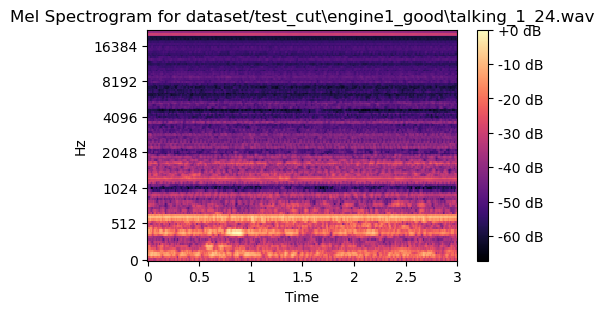

ไฟล์: dataset/test_cut\engine1_good\talking_1_24.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 20ms/step


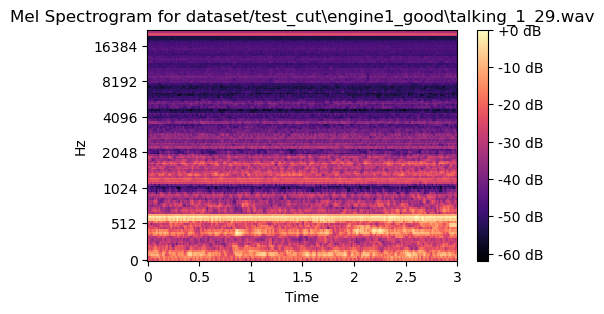

ไฟล์: dataset/test_cut\engine1_good\talking_1_29.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 20ms/step


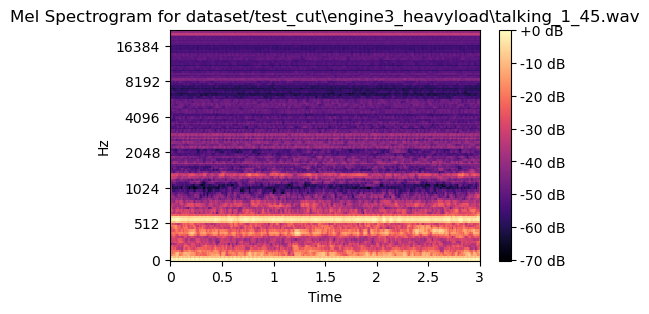

ไฟล์: dataset/test_cut\engine3_heavyload\talking_1_45.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 22ms/step


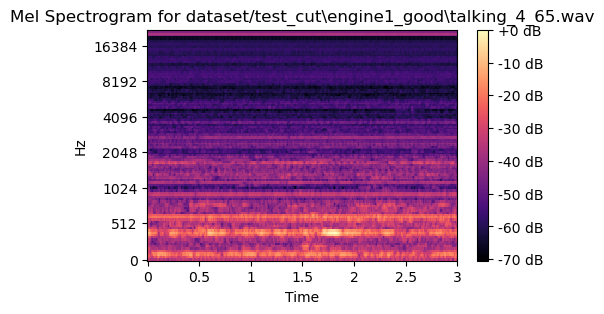

ไฟล์: dataset/test_cut\engine1_good\talking_4_65.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 21ms/step


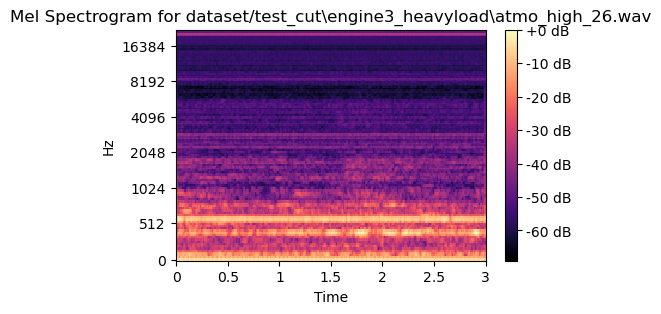

ไฟล์: dataset/test_cut\engine3_heavyload\atmo_high_26.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 19ms/step


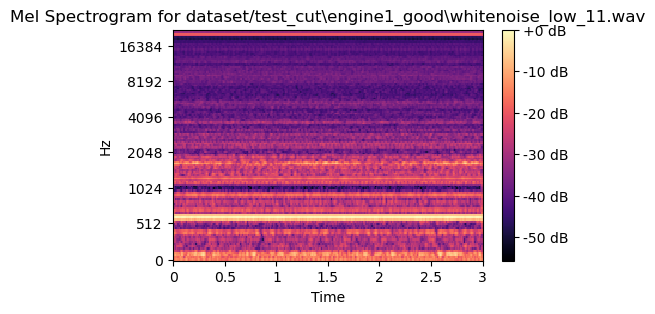

ไฟล์: dataset/test_cut\engine1_good\whitenoise_low_11.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 20ms/step


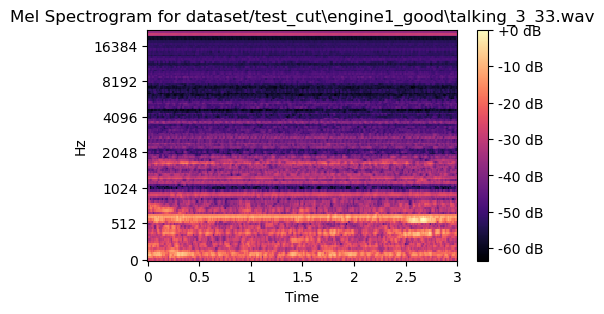

ไฟล์: dataset/test_cut\engine1_good\talking_3_33.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 18ms/step


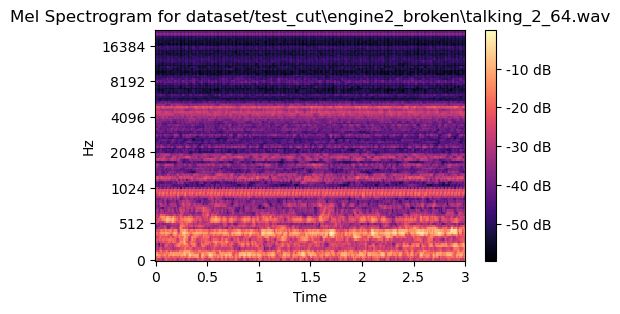

ไฟล์: dataset/test_cut\engine2_broken\talking_2_64.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 19ms/step


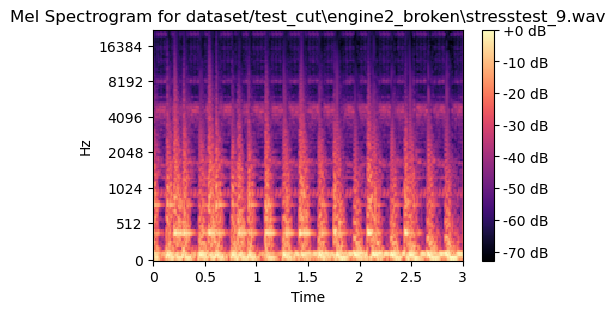

ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 17ms/step


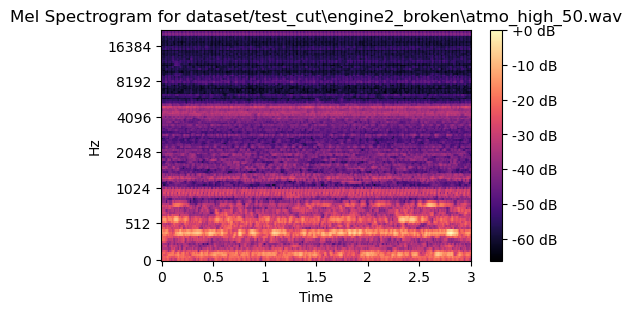

ไฟล์: dataset/test_cut\engine2_broken\atmo_high_50.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)



In [90]:
import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import resize

def visualize_random_files(model, X_test, y_test, X_test_filenames, classes, target_shape=(128, 128), num_files=10):
    """
    ฟังก์ชันแสดง Mel Spectrogram สำหรับไฟล์ที่สุ่มเลือกจากชุดข้อมูลทดสอบ
    Args:
        model: โมเดลที่ฝึกมาแล้ว
        X_test: ชุดข้อมูลทดสอบ (Mel spectrograms)
        y_test: คำตอบจริง (one-hot encoded labels)
        X_test_filenames: ชื่อไฟล์ของชุดทดสอบ
        classes: Dictionary ของชื่อคลาส
        target_shape: ขนาดของ Mel Spectrogram ที่จะใช้
        num_files: จำนวนไฟล์ที่ต้องการแสดง
    """
    # สุ่มไฟล์จากชุดทดสอบ
    random_indices = random.sample(range(len(X_test)), num_files)
    
    for idx in random_indices:
        # ทำนายผล
        prediction = model.predict(np.expand_dims(X_test[idx], axis=0))
        predicted_label = np.argmax(prediction, axis=1)
        true_label = np.argmax(y_test[idx], axis=0)
        
        # โหลดไฟล์เสียงและแปลงเป็น Mel spectrogram
        file_path = X_test_filenames[idx]
        audio_data, sample_rate = librosa.load(file_path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # แปลงเป็น dB scale
        
        # ปรับขนาดให้ตรงกับ target_shape
        mel_spectrogram_resized = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        
        # แสดง Mel Spectrogram
        plt.figure(figsize=(5, 3))
        librosa.display.specshow(mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram for {file_path}")
        plt.show()

        # แสดงผลการทำนายและคำตอบจริง
        predicted_class = list(classes.keys())[predicted_label[0]]
        true_class = list(classes.keys())[true_label]
        
        print(f"ไฟล์: {file_path}")
        print(f"ผลการทำนาย: {predicted_class} (คลาสที่ทำนาย: {predicted_label[0]})")
        print(f"คำตอบจริง: {true_class} (คลาสจริง: {true_label})\n")

# ตัวอย่างการใช้ฟังก์ชัน
visualize_random_files(model, X_test, y_test, X_test_filenames, classes, num_files=10)


1/1 [==============================] - 0s 19ms/step


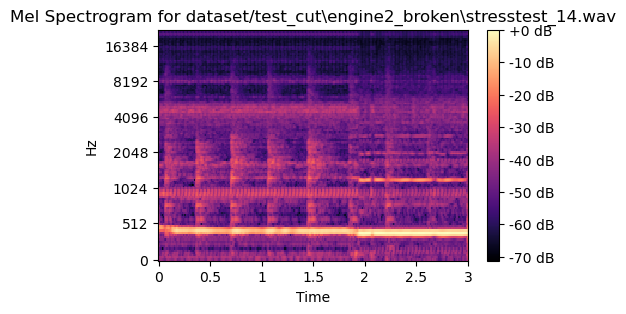

ไฟล์: dataset/test_cut\engine2_broken\stresstest_14.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 19ms/step
พบไฟล์ที่ทายผิดทั้งหมด 1 ไฟล์


In [91]:
visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes)

เพิ่มการใช้ Early stop

In [92]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)#กำหนด input layer โดยใช้ Input() และระบุ input_shape ซึ่งได้มาจาก X_train[0].shape
x = Conv2D(32, (3, 3), activation='relu')(input_layer)#ใช้ฟิลเตอร์ขนาด 3x3 มีจำนวนฟิลเตอร์ 32 ตัว ใช้ฟังก์ชัน ReLU เป็น Activation Function
x = MaxPooling2D((2, 2))(x)#ลดขนาด Feature Map ลงครึ่งหนึ่งโดยใช้ Max Pooling ขนาด 2x2
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)#แปลงข้อมูลจาก Feature Maps ไปเป็น เวกเตอร์ 1 มิติ เพื่อป้อนเข้าสู่ Fully Connected Layer
# x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)#Fully Connected Layer ขนาด 64 neurons พร้อมใช้ L2 Regularization (l2(0.001))
x = Dropout(0.5)(x)  # เพิ่ม Dropout ที่ 50%
output_layer = Dense(len(classes), activation='softmax')(x)#จำนวน neurons เท่ากับ จำนวนคลาส ใช้ Softmax เป็น activation function (เหมาะกับ Multi-class Classification)
model = Model(input_layer, output_layer)#สร้างโมเดลจาก input layer และ output layer

In [104]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,min_delta=0.001)


In [105]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stop])

Epoch 1/100
51/51 [==============================] - 3s 31ms/step - loss: 0.0102 - accuracy: 0.9981 - val_loss: 0.0344 - val_accuracy: 0.9926
Epoch 2/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1065 - accuracy: 0.9969 - val_loss: 0.0700 - val_accuracy: 0.9926
Epoch 3/100
51/51 [==============================] - 1s 24ms/step - loss: 0.1030 - accuracy: 0.9957 - val_loss: 0.1287 - val_accuracy: 0.9901
Epoch 4/100
51/51 [==============================] - 1s 24ms/step - loss: 0.0817 - accuracy: 0.9932 - val_loss: 0.8296 - val_accuracy: 0.9926
Epoch 5/100
51/51 [==============================] - 1s 24ms/step - loss: 0.0950 - accuracy: 0.9957 - val_loss: 0.0733 - val_accuracy: 0.9926
Epoch 6/100
51/51 [==============================] - 1s 24ms/step - loss: 0.0288 - accuracy: 0.9994 - val_loss: 0.2356 - val_accuracy: 0.9852


In [115]:
# Train loss & accuracy
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

# Test loss & accuracy
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print results
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Loss: 0.0288
Train Accuracy: 0.9994
Test Loss: 0.0344
Test Accuracy: 0.9926


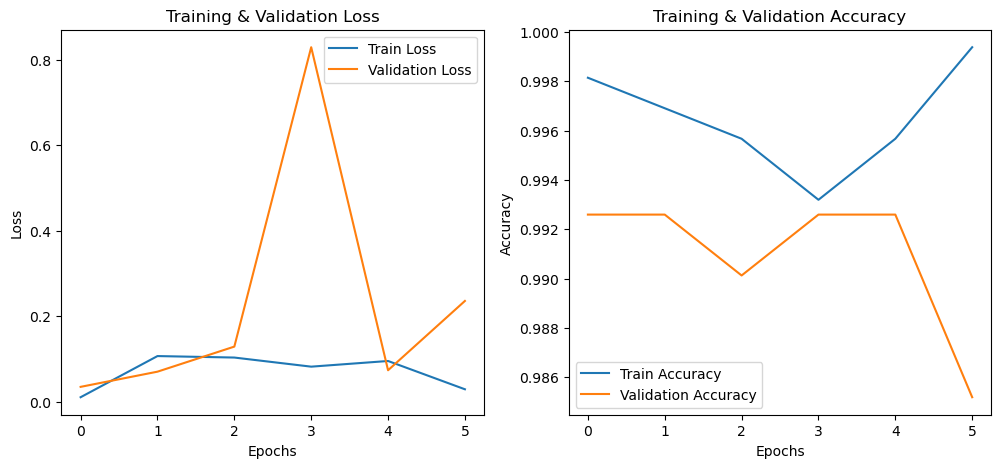

In [116]:
import matplotlib.pyplot as plt

# ดึงค่าประวัติการ train จาก model
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

13/13 [==============================] - 0s 34ms/step


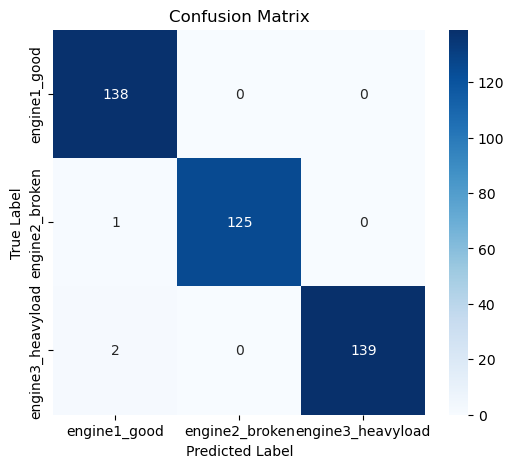


ไฟล์ที่ทายผิด:
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload
ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav, ทายเป็น: engine1_good, ค่าจริง: engine2_broken
ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav, ทายเป็น: engine1_good, ค่าจริง: engine3_heavyload


In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)

# แปลง one-hot encoding กลับเป็น label เดียว เช่น [0,1,0] → 1
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# คำนวณ Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# ชื่อคลาสจาก Dictionary ที่สร้างไว้
class_labels = list(classes.keys())

# แสดง Confusion Matrix ด้วย heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
# หาดัชนีที่ทายผิด
misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]

# แสดงรายการไฟล์ที่ทายผิด
print("\nไฟล์ที่ทายผิด:")
for idx in misclassified_indices:
    print(f"ไฟล์: {X_test_filenames[idx]}, ทายเป็น: {class_labels[y_pred_labels[idx]]}, ค่าจริง: {class_labels[y_true_labels[idx]]}")



In [122]:
from sklearn.metrics import classification_report

# ทำนายค่าบนชุดทดสอบ
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# ใช้ classification_report เพื่อแสดง Precision, Recall, F1-Score
print(classification_report(y_true_labels, y_pred_classes, target_names=class_labels))


13/13 [==============================] - 0s 26ms/step
                   precision    recall  f1-score   support

     engine1_good       0.98      1.00      0.99       138
   engine2_broken       1.00      0.99      1.00       126
engine3_heavyload       1.00      0.99      0.99       141

         accuracy                           0.99       405
        macro avg       0.99      0.99      0.99       405
     weighted avg       0.99      0.99      0.99       405



In [119]:
model.save('CNN-save2-epoch100-early.h5')

1/1 [==============================] - 0s 22ms/step


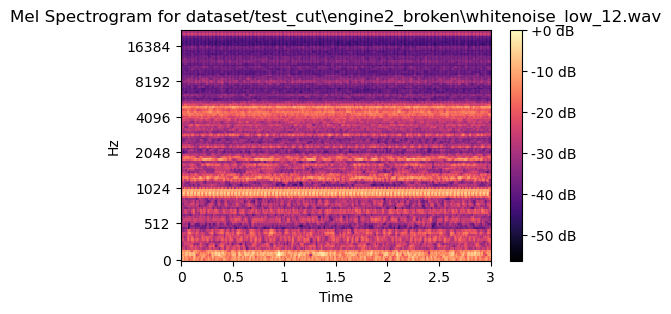

ไฟล์: dataset/test_cut\engine2_broken\whitenoise_low_12.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 18ms/step


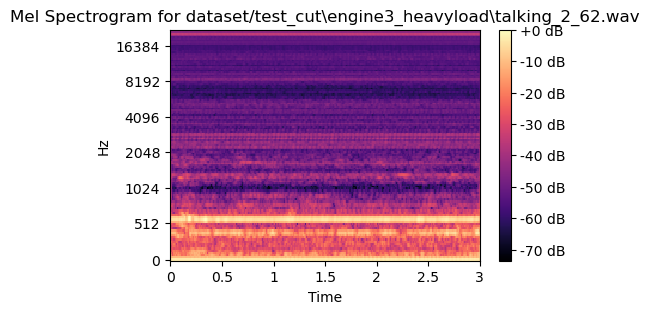

ไฟล์: dataset/test_cut\engine3_heavyload\talking_2_62.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 18ms/step


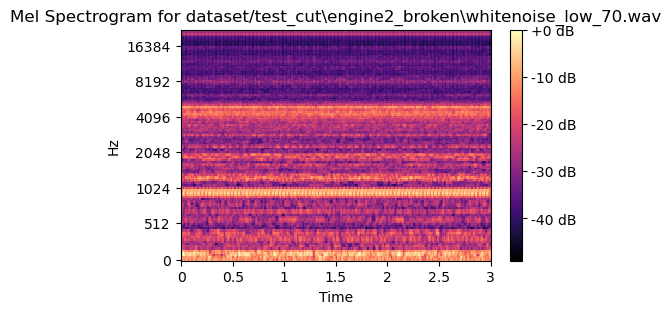

ไฟล์: dataset/test_cut\engine2_broken\whitenoise_low_70.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 18ms/step


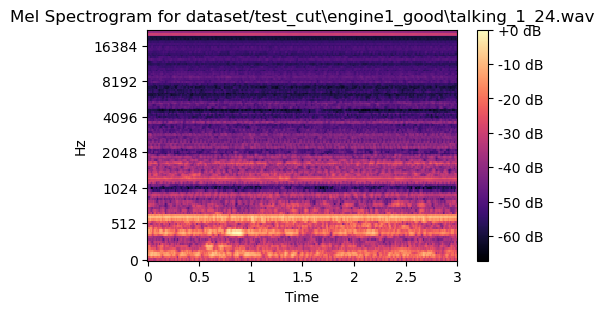

ไฟล์: dataset/test_cut\engine1_good\talking_1_24.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 19ms/step


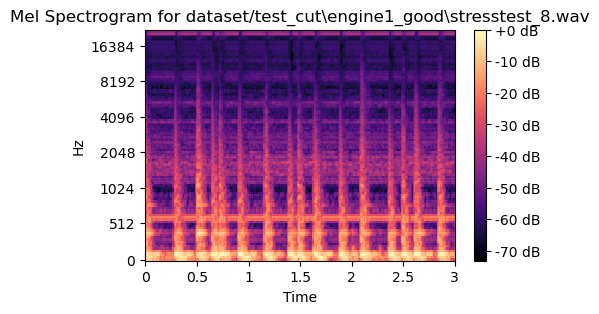

ไฟล์: dataset/test_cut\engine1_good\stresstest_8.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 16ms/step


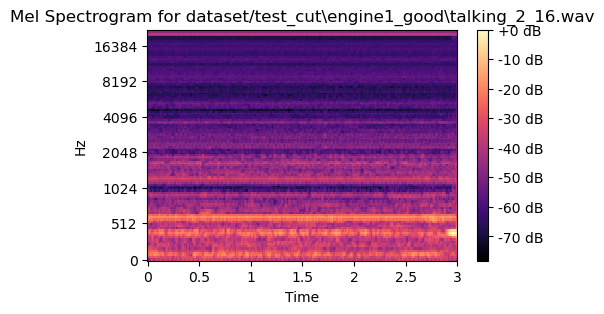

ไฟล์: dataset/test_cut\engine1_good\talking_2_16.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 21ms/step


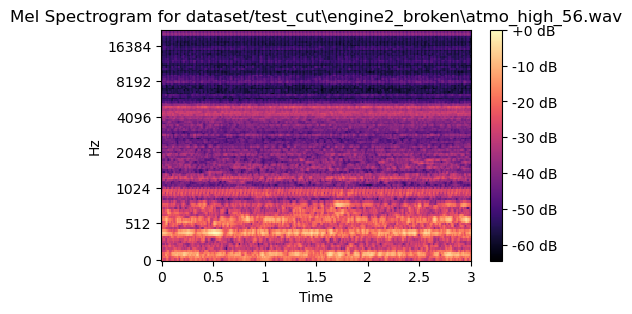

ไฟล์: dataset/test_cut\engine2_broken\atmo_high_56.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 21ms/step


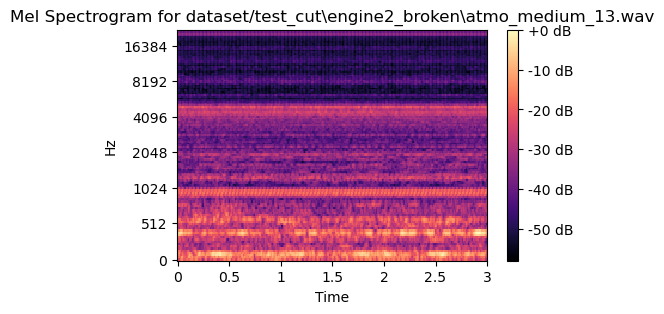

ไฟล์: dataset/test_cut\engine2_broken\atmo_medium_13.wav
ผลการทำนาย: engine2_broken (คลาสที่ทำนาย: 1)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 23ms/step


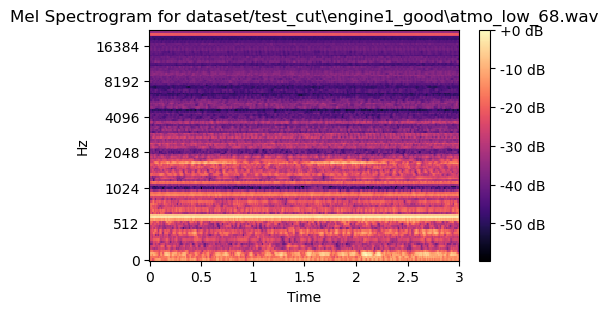

ไฟล์: dataset/test_cut\engine1_good\atmo_low_68.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine1_good (คลาสจริง: 0)

1/1 [==============================] - 0s 24ms/step


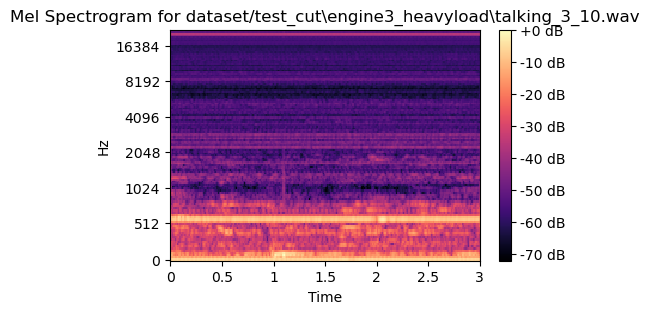

ไฟล์: dataset/test_cut\engine3_heavyload\talking_3_10.wav
ผลการทำนาย: engine3_heavyload (คลาสที่ทำนาย: 2)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)



In [120]:
visualize_random_files(model, X_test, y_test, X_test_filenames, classes, num_files=10)

1/1 [==============================] - 0s 21ms/step


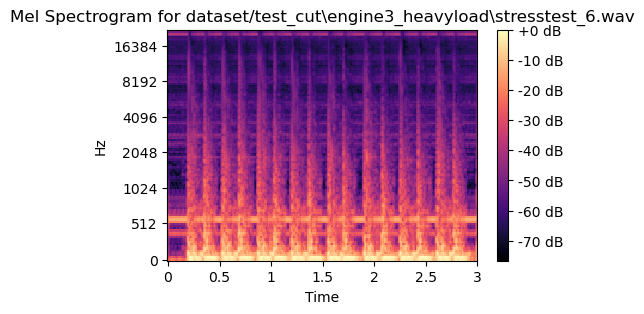

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_6.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 24ms/step


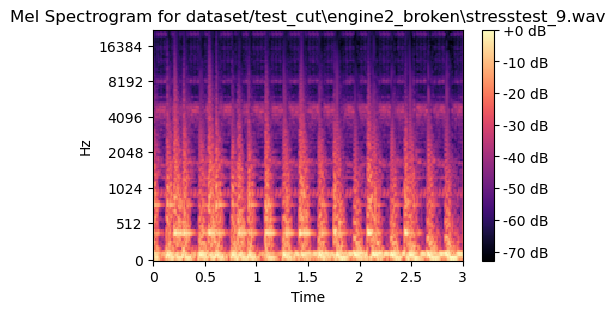

ไฟล์: dataset/test_cut\engine2_broken\stresstest_9.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine2_broken (คลาสจริง: 1)

1/1 [==============================] - 0s 20ms/step


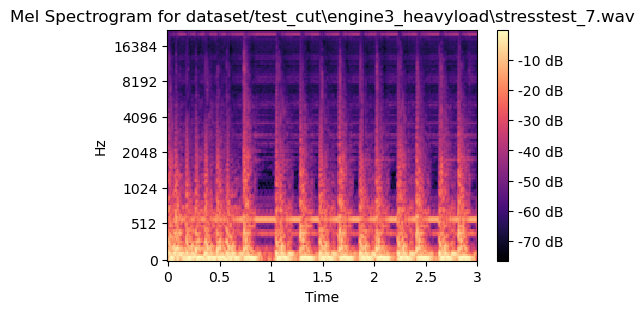

ไฟล์: dataset/test_cut\engine3_heavyload\stresstest_7.wav
ผลการทำนาย: engine1_good (คลาสที่ทำนาย: 0)
คำตอบจริง: engine3_heavyload (คลาสจริง: 2)

1/1 [==============================] - 0s 25ms/step
พบไฟล์ที่ทายผิดทั้งหมด 3 ไฟล์


In [121]:
visualize_misclassified_files(model, X_test, y_test, X_test_filenames, classes)